# **House Sale Price Predictor**

## Objectives

* Fit and evaluate a regression model to predict sale prices of inherited houses

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house prices
* Feature Importance Plot
* Model performance plot





---

## Install basic requirements

In [ ]:
%pip install -r ../requirements.txt

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing2/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing2'

## Load House Price Data

We will load the house prices dataset and check for any missing values in the variables, addressing them as necessary in the upcoming sections.

In [1]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv("outputs/datasets/collection/HousePrices.csv") 

# Print the shape of the dataset
print("Shape of the dataset:", df.shape)
print("First 3 rows of the dataset:")
print(df.head(3))

# Check for missing data
missing_data = df.isnull().sum()
print("\nColumns with missing data:")
print(missing_data[missing_data > 0])

Shape of the dataset: (1460, 24)
First 3 rows of the dataset:
   1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        150            0.0         548          RFn  ...         65.0   
1        284            NaN         460          RFn  ...         80.0   
2        434            0.0         608          RFn  ...         68.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0       196.0          61            5            7          856         0.0   
1         0.0           0            8            6         1262         NaN   
2       162.0          42            5            7          920         NaN   

   YearBuil

---

# Create Machine Learning Pipeline
* The pipeline will be of type regression.

## Import libraries

In [2]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer

### Feature Engineering
from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Create Pipeline Model

In [3]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.outliers   import Winsorizer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Feature Selection
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

## Optimize Hyperparameter - GridSearchCV

In [4]:
# Code from Code institute walkthrough project
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Data Test Set

In [5]:
from sklearn.model_selection import train_test_split
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from sklearn.impute import SimpleImputer

# Perform imputation methods on the DataFrame
df_imputed = df.copy()

# Impute missing values for numerical variables
imputer_num = MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])
df_imputed = imputer_num.fit_transform(df_imputed)

# Impute missing values for categorical variables
imputer_cat = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])
df_imputed = imputer_cat.fit_transform(df_imputed)

# Impute missing values for EnclosedPorch and WoodDeckSF with 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_imputed[['EnclosedPorch', 'WoodDeckSF']] = imputer.fit_transform(df_imputed[['EnclosedPorch', 'WoodDeckSF']])

# Create X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(
    df_imputed.drop(['SalePrice'], axis=1),
    df_imputed['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


# Verify no missing values in the Train Data Set

In [6]:
# Check for missing values in X_train
missing_values = X_train.isnull().sum()

# Filter variables with missing values
variables_with_missing_values = missing_values[missing_values > 0]

# Print variables with missing values
print("Variables with missing values:")
print(variables_with_missing_values)

Variables with missing values:
Series([], dtype: int64)


## Cross Validate Grid Search - Sklearn 
* Identify most suitable algorithm using default hyperparameters

In [7]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

## Present the result of the grid search cross-validation

In [1]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

best_model = grid_search_summary.iloc[0, 0]
best_model

NameError: name 'HyperparameterOptimizationSearch' is not defined

## Detail search for suitable hyperparameters

We identified the GradientBoostingRegressor as the most suitable model in the previous section.

In [9]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# In a workplace project, you may consider more hyperparameters and spend more time in this step
# https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html

params_search = {
    "GradientBoostingRegressor": {
          # 'model__n_estimators': [50, 75, 100], # gives little improvements we stick to default = 100
          # 'model__max_depth': [3, 5, 10], # gives little improvement we stick to default = 3
          'model__learning_rate': [0.05], # This learning rate consistently gave the best r2 scores, default = 0.1
          # 'model__learning_rate': [0.05, 0.07, 0.1], # default = 0.1
          # 'model__min_samples_split': [2, 25, 50, 75], # setting this to 75 also gives very good results, but we will stick to the default = 2
          # 'model__min_samples_leaf': [1, 25, 50, 75], # changing this parameter also seems to cause slight overfitting - keep default = 1
          # 'model__max_leaf_nodes': [None, 25, 50, 75], # Changing this parameter seems to often cause slight overfitting - keep default = None
    }
}

## Display the results of the extensive search for hyperparameters

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

In [11]:
best_model = grid_search_summary.iloc[0, 0]
best_model

best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['1stFlrSF', '2ndFlrSF',
                                                   'BedroomAbvGr', 'BsmtFinSF1',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   'GarageArea', 'GrLivArea',
                                                   'LotArea', 'LotFrontage',
                                                   'MasVnrArea',
                                                   'OpenPorchSF'])),
                ('CategoricalImputer'...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
         

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


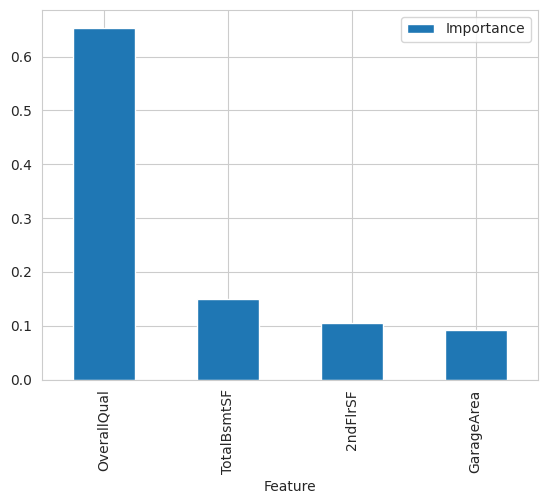

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 10 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Train and Test Data Sets

In [13]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

## Display performance and evalutation plots for the regressor model

Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 19137.251
Mean Squared Error: 699331013.628
Root Mean Squared Error: 26444.867


* Test Set
R2 Score: 0.84
Mean Absolute Error: 22239.394
Mean Squared Error: 1107161898.508
Root Mean Squared Error: 33274.042




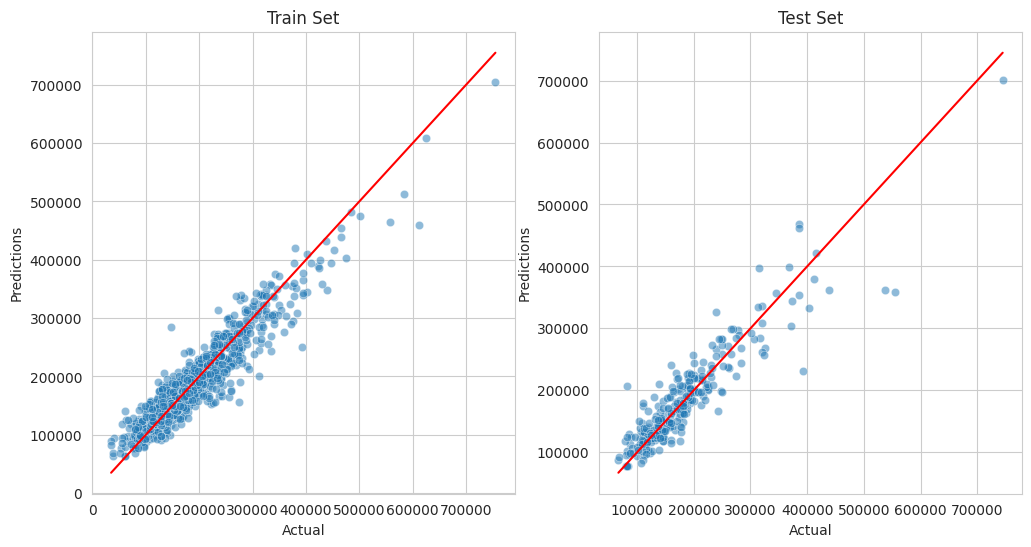

In [14]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Principle Component Analysis (Regressor)

In the previous regression, we noticed promising results concerning the R² score for both the training and test datasets. The trendline follows the data cluster without any indication of overfitting. However, we want to test if PCA will generate results with even higher confidence.

## Transform PCA Pipeline

In [15]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:10])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'pandas.core.frame.DataFrame'>


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


## Analyze PCA components

* The 17 components explain 100.0% of the data 



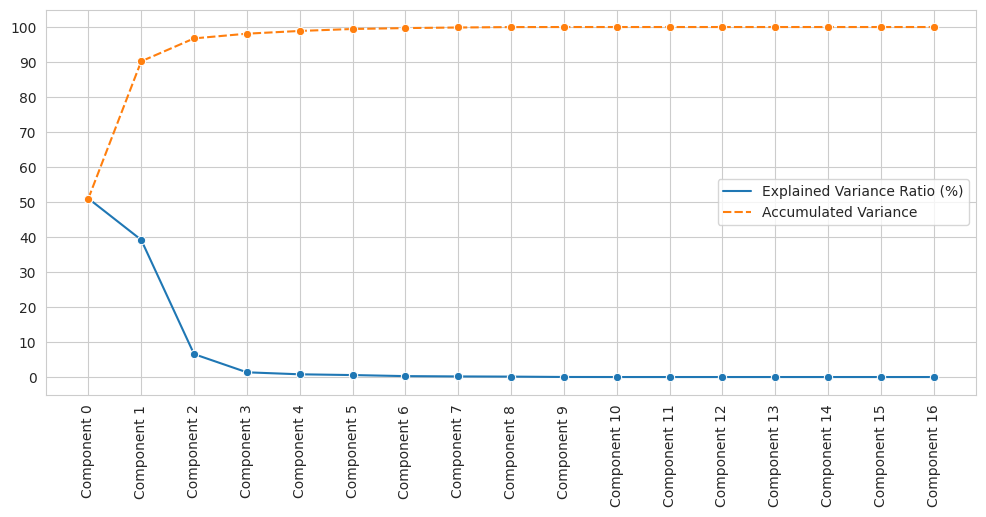

In [16]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Perform PCA for most significant components

* The 4 components explain 98.1% of the data 



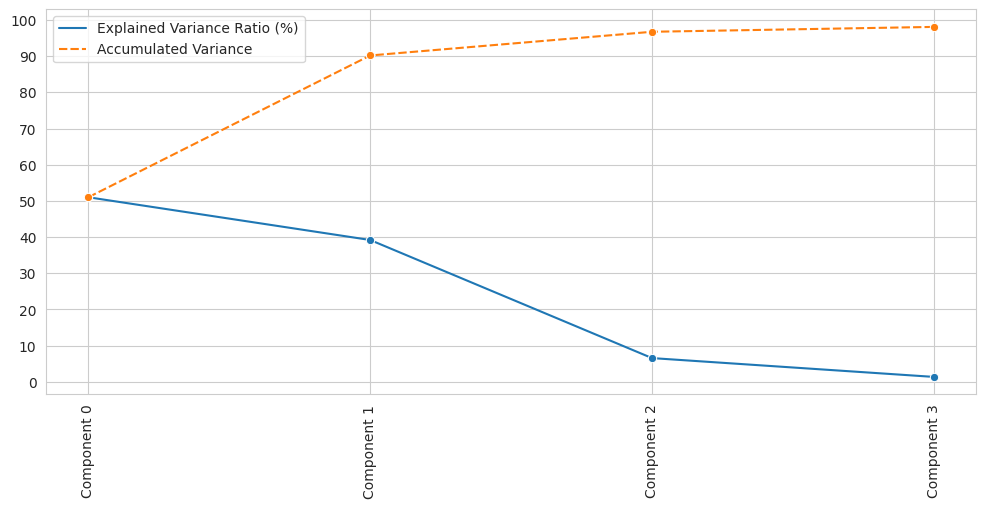

In [17]:
n_components = 4
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Preprocess data for pipeline with PCA

In [18]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder

# Create the pipeline for imputation, encoding, and PCA
pipeline = Pipeline([
    # Impute missing values for numerical variables
    ("imputer_num", MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF', 'MasVnrArea', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'WoodDeckSF', 'EnclosedPorch'])),
    
    # Impute missing values for categorical variables
    ("imputer_cat", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),
    
    # Encode categorical variables
    ("encoder", OrdinalEncoder(encoding_method='arbitrary', 
                               variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure', 'KitchenQual'])),
    
    # Apply PCA
    ("pca", PCA(n_components=4))  # Modify n_components as needed
])

# Fit and transform the data
df_pca = pipeline.fit_transform(df.drop(['SalePrice'], axis=1))

# Check the result
print(df_pca.shape, '\n', type(df_pca))



(1460, 4) 
 <class 'numpy.ndarray'>


# Rewrite the ML Pipeline for Modelling using PCA

In [19]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Principle Component Analysis
        ("PCA", PCA(n_components=4, random_state=0)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [20]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [21]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [22]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [23]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.670019,0.73341,0.807928,0.044386
5,GradientBoostingRegressor,0.610125,0.728766,0.796547,0.06254
3,ExtraTreesRegressor,0.593063,0.720547,0.808578,0.070307
6,XGBRegressor,0.625331,0.708058,0.768697,0.0466
0,LinearRegression,0.640613,0.689321,0.746614,0.03518
4,AdaBoostRegressor,0.586708,0.660877,0.770249,0.062313
1,DecisionTreeRegressor,0.43524,0.544961,0.659983,0.073943


In [24]:
# defining model parameters for a more extensive search - we only test 3 parameters. It is unlikely that we will get any improvement over the 
# initial pipeline with 4 important features used.

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [20, 50, 100, 300],
        'model__max_depth': [3,5,8],
        'model__learning_rate': [0.03, 0.05, 0.07, 0.1],
    }
}

In [25]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [28]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
29,GradientBoostingRegressor,0.655916,0.737026,0.790031,0.044959,0.07,5,50
17,GradientBoostingRegressor,0.665,0.734936,0.7862,0.039358,0.05,5,50
6,GradientBoostingRegressor,0.649494,0.73467,0.79589,0.04758,0.03,5,100
37,GradientBoostingRegressor,0.623121,0.733292,0.800481,0.058917,0.1,3,50
30,GradientBoostingRegressor,0.64057,0.733099,0.786432,0.049323,0.07,5,100
25,GradientBoostingRegressor,0.646601,0.732501,0.803954,0.050369,0.07,3,50
18,GradientBoostingRegressor,0.650292,0.732339,0.780414,0.043604,0.05,5,100
26,GradientBoostingRegressor,0.621261,0.732013,0.805434,0.060218,0.07,3,100
14,GradientBoostingRegressor,0.620928,0.731666,0.809949,0.061408,0.05,3,100
7,GradientBoostingRegressor,0.633753,0.730426,0.7869,0.051204,0.03,5,300


## Identify and store the suitable ML Pipeline

In [26]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Feature Selection
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [27]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100],
        'model__max_depth': [3],
        'model__learning_rate': [0.05],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [None],
    }
}

Display the suitbale pipeline


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 19137.251
Mean Squared Error: 699331013.628
Root Mean Squared Error: 26444.867


* Test Set
R2 Score: 0.84
Mean Absolute Error: 22239.394
Mean Squared Error: 1107161898.508
Root Mean Squared Error: 33274.042




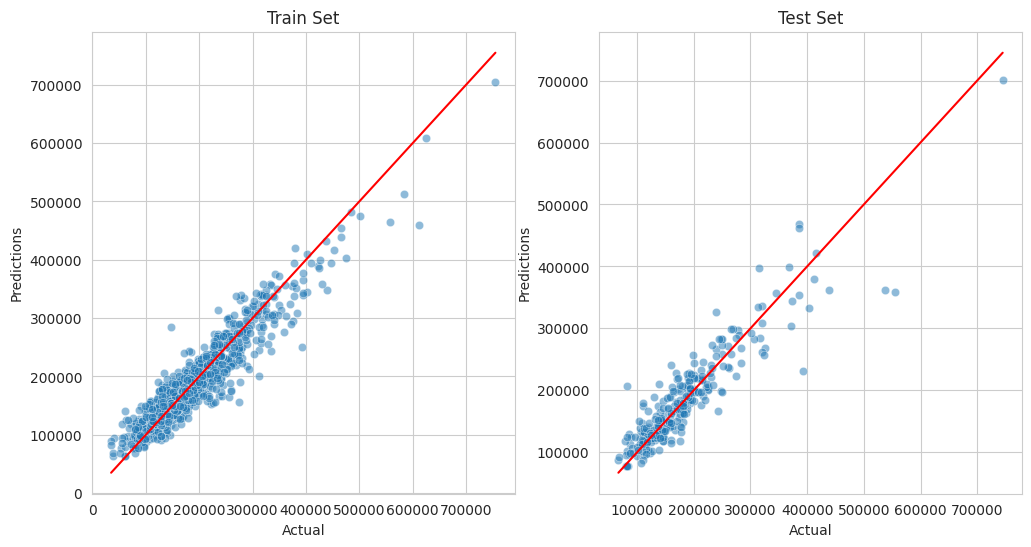

In [28]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

best_model = grid_search_summary.iloc[0,0]
best_model

# Defining the best pipeline

pipeline_regression = grid_search_pipelines[best_model].best_estimator_
pipeline_regression

regression_performance(X_train, y_train, X_test, y_test, pipeline_regression)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)

---

NOTE

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [29]:
import joblib
import os

# Define the version and file path relative to the project's root directory
version = 'v14_test'
file_path = os.path.join('/workspace/heritage-housing2/outputs/ml_pipeline/predict_sale_price', version)

try:
    os.makedirs(file_path, exist_ok=True)
except Exception as e:
    print(e)

## Train Set : features and target

In [30]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
618,1828,0.0,3.0,Av,48,Unf,1774,0.0,774,Unf,...,11694,90.0,452.0,108,5,9,1822,0.0,2007,2007
870,894,0.0,2.0,No,0,Unf,894,0.0,308,Unf,...,6600,60.0,0.0,0,5,5,894,0.0,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,0.0,432,Unf,...,13360,80.0,0.0,0,7,5,876,0.0,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,0.0,857,RFn,...,13265,69.0,148.0,59,5,8,1568,0.0,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,0.0,843,RFn,...,13704,118.0,150.0,81,5,7,1541,0.0,2001,2002


In [31]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [36]:
y_train.head()

921     145900
520     106250
401     164990
280     228500
1401    193000
Name: SalePrice, dtype: int64

In [32]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

X_test.head()

In [33]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [34]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [35]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [36]:
pipeline_regression

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['1stFlrSF', '2ndFlrSF',
                                                   'BedroomAbvGr', 'BsmtFinSF1',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   'GarageArea', 'GrLivArea',
                                                   'LotArea', 'LotFrontage',
                                                   'MasVnrArea',
                                                   'OpenPorchSF'])),
                ('CategoricalImputer'...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
         

In [37]:
joblib.dump(value=pipeline_regression, filename=f"{file_path}/regression_pipeline.pkl")

['/workspace/heritage-housing2/outputs/ml_pipeline/predict_sale_price/v14_test/regression_pipeline.pkl']

## Feature Importance Plot 

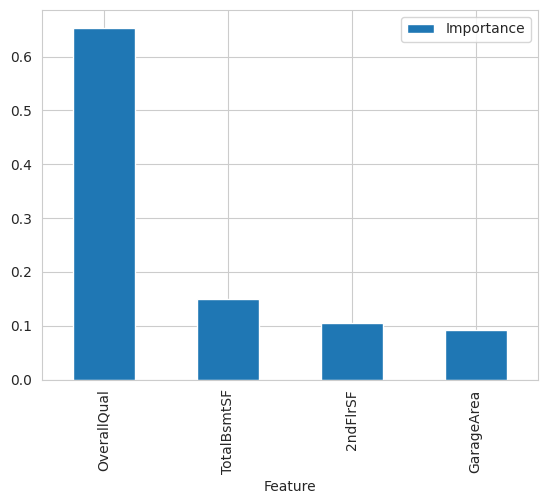

In [38]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

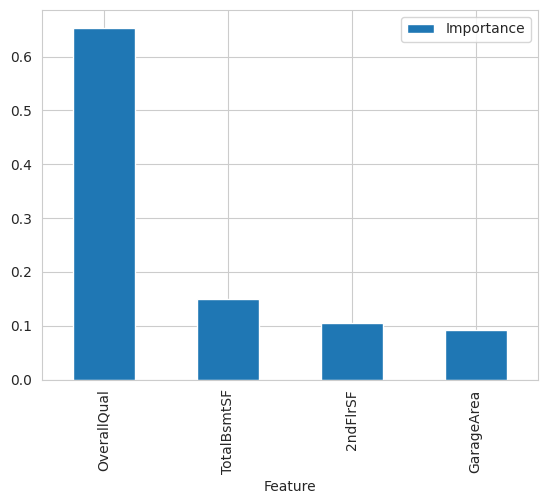

In [39]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

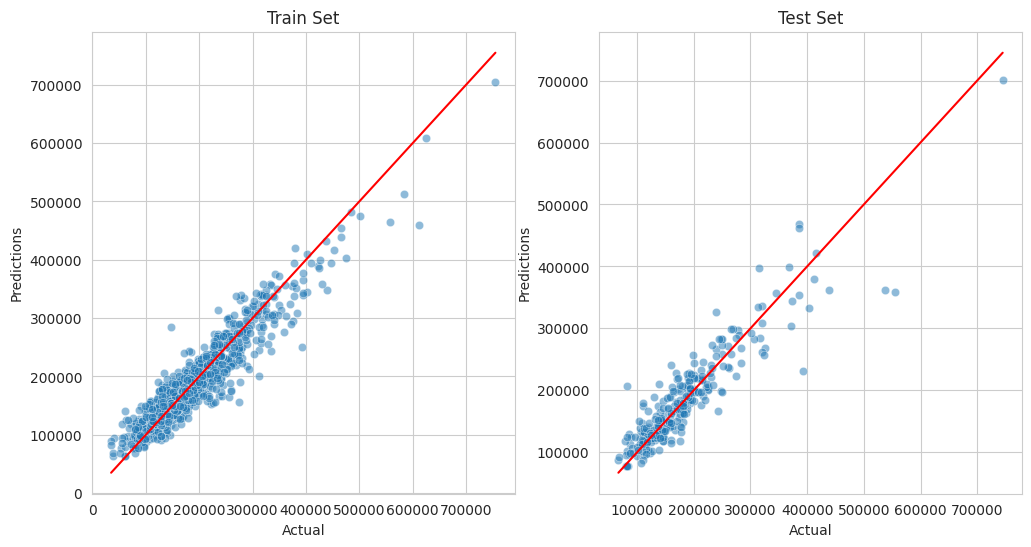

In [40]:
def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    # plt.show()
    plt.savefig(f'{file_path}/model_performance_evaluation.png', bbox_inches='tight')

regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_regression)